# Note: To generate the panels for Figure 6 and S5, run this code twice - once for LHb data and once for VTA data.

In [1]:
## load required packages ##
import os
import matplotlib.pyplot as plt
import pylab as p
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
from os import listdir
import csv
import math
import pandas as pd
import scipy.integrate 
import scipy.io as sio
from IPython.core.display import display, HTML
from __future__ import division
import pickle
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyamg
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import IntProgress
from IPython.display import display
import time

In [2]:
## EDIT THIS SECTION | FILE & DIRECTORY INFO, HOUSEKEEPING ##
basedir1 = "\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\LHb\\fed"
basedir2 = "\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\LHb\\fast"
condition = ['fed','fast']
projection='LHb'

lickalignfile='TRACKED_fissa_lick_align.npy'  #Lick aligned file name
signalsfile='BL_TRACKED_extractedsignals_fissa_decon.npy'  #Baseline file name

fissa=['yes'] ## are the files fissa decontaminated?

filename='LHb_satiety' ## name to be appended to saved files/figs

## Save Figures?
save_figs=['yes']

## Fig file type
fig_style='pdf' ##png, pdf, tif

## Save data files?
save_files=['yes']

maxnumneurons = 1000 #used to initialize arrays. Should be larger than the total number of neurons
framerate=5

## Color palatte ##
cmap=sns.diverging_palette(200, 275, sep=50, as_cmap=True, center='dark') ##Green-Purple
#cmap = sns.diverging_palette(230, 5, sep=20, as_cmap=True, center='dark') ###Teal-Pink
#cmap=sns.diverging_palette(220, 35, sep=100, as_cmap=True, center='dark') ###Teal-Gold

## Colors for bar/line plots (order reflects order of 'condition' above) ##
colors = ['lightseagreen','magenta']

In [3]:
### EDIT THIS SECTION | SET PARAMS FOR SUCROSE ANALYSIS ###
maxtrials=20    #number of trials
framespertrial=100 #frames per trial in lick align file
numpreframes=35 #frames before first lick

## normalize data by baseline?
normalize_on=['yes']
baseline=[20,35]
test=[35,65] ##used to calc significance

In [4]:
### EDIT THIS SECTION | SET PARAMS FOR BASELINE ANALYSIS ###
## Do you want to use F/F0 or z-scored data?
use_raw_data=['no'] ## if 'no' then data will be z-scored
raw_threshold=1.1  #define raw threshold value for identifying events
z_threshold=1.25      #define z threshold value for identifying events

### Filter the event by duration or area under the curve (values of 0 = unfiltered)
timethreshold=1  #threshold for duration of event (in seconds) 
areathreshold=0  #threshold for area under the curve of event

#do you want to use the low-pass filter to adjust the z-score values?
low_pass_filter_on=['no'] #either 'yes' or 'no'
lowpass_filter=100 # Change this to modify the low-pass correction. (values between 1.05 and 1.1 seem to work well)

#do you want to PLOT all individual traces? (if you have a lot of cells, this can be pretty time consuming)
plot_traces=['no'] ##plot unfiltered traces?
plot_traces_filtered=['no'] ##plot filtered traces?

## if you want to limit your analysis to a certain range of frames, change start_frame and end_frame below
start_frame=0 
maxframes=1500 
end_frame=maxframes ## change to value to limit BL analysis

rolling_bin=3 #rolling average smooth; greater values increase the smoothing

## END NECESSARY EDITS ##

In [5]:
## DO NOT EDIT - set path, create output directories, save params ##
if fissa[0]=='yes':
    filename=filename+'_fissa'
else:
    filename=filename
os.chdir(basedir1)
os.chdir('..')
try:
    os.mkdir(filename+'_OUTPUT')
except OSError:
    print ("Creation of the directory %s failed" % filename+'_OUTPUT')
else:
    print ("Successfully created the directory %s " % filename+'_OUTPUT')
os.chdir(filename+'_OUTPUT')
try:
    os.mkdir('BL')
    os.mkdir('Sucrose')
    os.mkdir('Behavior')
    os.mkdir('SVM')
except OSError:
    pass
%pwd

#save parameters to csv
params=['Lick align file: '+str(lickalignfile),'Baseline file: '+str(signalsfile),
        'Trials: '+str(maxtrials),'Frames per trial: '+str(framespertrial),
        'Lick occurs at frame: '+str(numpreframes), 'Normalize sucrose by baseline? '+str(normalize_on[0]),
        'Sucrose baseline period (frames): '+str(baseline), 'Sucrose test period (frames): '+str(test),
        'framerate = '+str(framerate),'z-threshold = '+str(z_threshold),'raw threshold = '+str(raw_threshold),
        'time threshold = '+str(timethreshold),
         'area threshold = '+str(areathreshold),'low pass filter on? = '+low_pass_filter_on[0],
         'low pass filter = '+str(lowpass_filter),'start frame = '+str(start_frame),'end frame = '+str(end_frame),
         'use raw data? = '+str(use_raw_data[0])]
with open(filename+'_analysis_parameters.csv','wb') as myfile:
    out=csv.writer(myfile,delimiter=',',dialect='excel',quoting=csv.QUOTE_ALL)
    out.writerow(params)

Creation of the directory LHb_satiety_fissa failed_OUTPUT


In [6]:
## DO NOT EDIT -  Load files in basedir1 and basedir2 ##
def load_files(directory):
    signals_pop = np.nan*np.zeros((maxtrials,framespertrial,maxnumneurons))
    trials_pop=np.nan*np.zeros((maxnumneurons))
    data_dirs = os.walk(directory).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        try:
            signals=np.load(os.path.join(directory,data_dir,lickalignfile))
        except:
            continue
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        numtrials=signals.shape[0]
        for a in range(0,numneurons):
            signals_pop[0:numtrials,0:signals.shape[1],numneuronstillnow+a]=signals[0:maxtrials,:,a]
            trials_pop[numneuronstillnow:numneuronstillnow+a+1]=numtrials
        numneuronstillnow += numneurons
    extractedsignals=signals_pop[:,:,:numneuronstillnow]
    trials_pop=trials_pop[:numneuronstillnow]
    print '\nfiles = '+str(data_dirs)
    print 'Number of neurons = '+str(extractedsignals.shape[2])
    print 'Number of frames per trial = '+str(extractedsignals.shape[1])
    return extractedsignals,numneuronstillnow,numframes,numneurons,numtrials,trials_pop
extractedsignals1,numneuronstillnow1,numframes1,numneurons1,numtrials1,trials_pop1=load_files(basedir1)
extractedsignals2,numneuronstillnow2,numframes2,numneurons2,numtrials2,trials_pop2=load_files(basedir2)


files = ['AH10', 'AH11', 'AH12', 'AH5', 'AH6']
Number of neurons = 160
Number of frames per trial = 100

files = ['AH10', 'AH11', 'AH12', 'AH5', 'AH6']
Number of neurons = 160
Number of frames per trial = 100


In [7]:
## DO NOT EDIT - z-score data if using fissa files ##
def normfissa(data):
    if filename[-5:]=='fissa':
        print '*** FISSA data detected - Normalizing ***'
        temp1=np.nan*np.zeros((data.shape))
        for a in range(data.shape[2]):
            temp1[:,:,a]=data[:,:,a]/np.nanmean(data[:,:,a])
        data=temp1
    return data
extractedsignals1=normfissa(extractedsignals1)
extractedsignals2=normfissa(extractedsignals2)

*** FISSA data detected - Normalizing ***
*** FISSA data detected - Normalizing ***


In [8]:
## DO NOT EDIT - normalize data by baseline period ##
if normalize_on[0]=='yes': 
    def normalize_data(data):
        BLnorm=np.nan*np.zeros((data.shape))
        BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
        for b in range(0,data.shape[2]):
            for a in range(0,data.shape[0]):
                BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        for e in range(0,data.shape[2]):
            for d in range(0,data.shape[1]):
                for c in range(0,data.shape[0]):
                    BLnorm[c,d,e]=data[c,d,e]-BLavg[c,e]
        reshape_response=BLnorm
        return reshape_response
    extractedsignals1_norm=normalize_data(extractedsignals1)
    extractedsignals2_norm=normalize_data(extractedsignals2)
else:
    extractedsignals1_norm=extractedsignals1
    extractedsignals2_norm=extractedsignals2

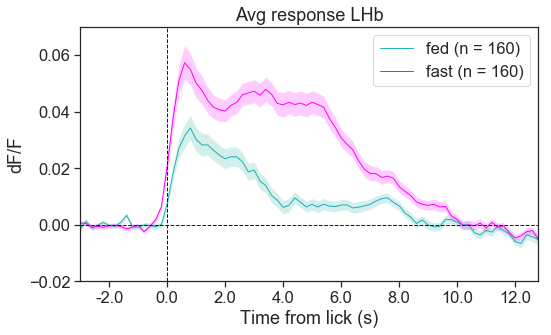

In [9]:
## Fig 6C (bottom): Fed pop average ##
ymin=-.02
ymax=.07

avg_response1=np.nanmean(extractedsignals1_norm,axis=0)
avg_response2=np.nanmean(extractedsignals2_norm,axis=0)
peak_response1=np.nanmax(avg_response1[test[0]:test[1],:],axis=0)
peak_response2=np.nanmax(avg_response2[test[0]:test[1],:],axis=0)
avg_rew_response1=np.nanmean(avg_response1[test[0]:test[1],:],axis=0)
avg_rew_response2=np.nanmean(avg_response2[test[0]:test[1],:],axis=0)
if save_files[0]=='yes':
    np.savetxt('Sucrose/'+filename+'_avg_suc_response_'+condition[0]+'.csv',avg_rew_response1.T,delimiter=',')
    np.savetxt('Sucrose/'+filename+'_avg_suc_response_'+condition[1]+'.csv',avg_rew_response2.T,delimiter=',')
    np.savetxt('Sucrose/'+filename+'_peak_suc_response_'+condition[0]+'.csv',peak_response1.T,delimiter=',')
    np.savetxt('Sucrose/'+filename+'_peak_suc_response_'+condition[1]+'.csv',peak_response2.T,delimiter=',')
    np.savetxt('Sucrose/'+filename+'_all_suc_data_'+condition[0]+'.csv',avg_response1.T,delimiter=',')
    np.savetxt('Sucrose/'+filename+'_all_suc_data_'+condition[1]+'.csv',avg_response2.T,delimiter=',')
#remove frames preceding start of baseline window
avg_response1=avg_response1[baseline[0]:,:]
avg_response2=avg_response2[baseline[0]:,:]
framespertrial=framespertrial-baseline[0]

sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 8})
fig1,ax = plt.subplots(1,1,figsize=(8,5))
sns.tsplot(avg_response1.T,color=colors[0], condition=condition[0]+' (n = '+str(extractedsignals1.shape[2])+')', legend=True)
sns.tsplot(avg_response2.T,color=colors[1], condition=condition[1]+' (n = '+str(extractedsignals2.shape[2])+')', legend=True)
ax.set_title('Avg response '+projection)
ax.set_xlabel('Time from lick (s)')
ax.set_ylabel('dF/F')
ax.set_ylim(ymin,ymax)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)])
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [ymin, ymax], '--k', linewidth=1)
plt.axhline(y=0, linestyle='--', linewidth=1, color='k')
fig1.tight_layout(w_pad=5)
if save_figs[0]=='yes':
    plt.savefig(('Sucrose/'+filename+'_pop_suc_response_overlay.'+fig_style), format=str(fig_style))
    plt.show()

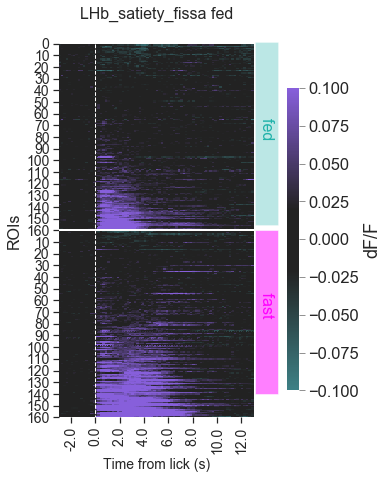

In [10]:
## combine groups and plot on same heatmap ##
def combinedheatmap(data1,data2,title,sorton):
    ymin=-.1
    ymax=.1
    if sorton=='yes':
        sort1=np.squeeze(np.argsort(np.nanmean(data1[numpreframes-baseline[0]:(numpreframes-baseline[0])+(test[1]-test[0])], axis=0, keepdims=True)))
        data1=data1[:,sort1]
        sort2=np.squeeze(np.argsort(np.nanmean(data2[numpreframes-baseline[0]:(numpreframes-baseline[0])+(test[1]-test[0])], axis=0, keepdims=True)))
        data2=data2[:,sort2]       
    data=np.concatenate((data1,data2),axis=1)
    
    ylabel1=range(0,data1.shape[1]+1,10)
    ylabel2=range(10,data2.shape[1]+1,10)
    ylabels=ylabel1+ylabel2
    
    fig2 = plt.figure(2,figsize=(8,7))
    cbar_ax = fig2.add_axes([.52, .2, .02, .6])
    cbar_ax.tick_params(width=0.5) 
    
    ax = plt.subplot(121)
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    sns.heatmap(data.T, cmap=cmap, vmin=ymin, vmax=ymax,linewidth=0,cbar_ax=cbar_ax,rasterized=True)
    cbar_ax.set_ylabel('dF/F')
    ax.set_title(filename+' '+str(condition[0]), fontsize=16,position=[0.5,1.05])
    ax.set_xlabel('Time from lick (s)', fontsize=14)
    ax.set_xticks(range(5, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
    ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, data.shape[1]], '--w', linewidth=1)
    ax.axhline(y=data1.shape[1], color='white', linewidth=2)
    ax.set_yticks(range(0, data.shape[1]+1, 10))
    ax.set_yticklabels(ylabels,fontsize='14')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')
    plt.ylabel('ROIs', fontsize='16')
    
    ## control text boxes
    offset=[82,12] ##related to specified plot size. change as needed
    
    ## bottom text box
    ax.text(offset[0],offset[1], '                '+condition[0]+'                  '
            ,fontsize=16,color=colors[0],rotation=270
            ,bbox={'facecolor':colors[0],'alpha':0.3,'pad':4})
    
    ## top text box
    ax.text(offset[0],offset[1]+data1.shape[1]+1, '             '+condition[1]+'                '
            ,fontsize=16,color=colors[1],rotation=270
            ,bbox={'facecolor':colors[1],'alpha':0.5,'pad':4})
    
    fig2.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig(('Sucrose/'+filename+'_'+title+'.'+fig_style), format=str(fig_style))
    plt.show()
combinedheatmap(avg_response1,avg_response2,"combined_pop_heatmap_sorted",sorton='yes')

In [11]:
## DO NOT EDIT - Function to plot bars to compare conditions ##
def bar_plot(data1,data2,ytitle,directory,param):
    if param=='Median':
        try:
            if data1.shape[1]>0:
                data1=np.nanmedian(data1,axis=1)
                data1=data1[~np.isnan(data1)]
                data2=np.nanmedian(data2,axis=1)
                data2=data2[~np.isnan(data2)]
        except:
            pass
        means=np.nan*np.zeros((1,2))
        means[:,0]=np.nanmedian(data1)
        means[:,1]=np.nanmedian(data2)
        means=np.squeeze(means)
        try:
            t,p=np.around(stats.wilcoxon(data1,data2),decimals=3)
            test='Wilcoxon Rank Sum'
        except:
            t,p=np.around(stats.ttest_ind(data1,data2),decimals=3)
            test='t-test'
        sems=np.nan*np.zeros((1,2))
        sems[:,0]= stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)

    else:
        test='t-test'
        try:
            if data1.shape[1]>0:
                data1=np.nanmean(data1,axis=1)
                data1=data1[~np.isnan(data1)]
                data2=np.nanmean(data2,axis=1)
                data2=data2[~np.isnan(data2)]
        except:
            pass
        means=np.nan*np.zeros((1,2))
        means[:,0]=np.nanmean(data1)
        means[:,1]=np.nanmean(data2)
        means=np.squeeze(means)
        t,p=np.around(stats.ttest_ind(data1,data2),decimals=3)
        sems=np.nan*np.zeros((1,2))
        sems[:,0]=stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)

    combinedata=np.nan*np.zeros((max(data1.shape[0],data2.shape[0]),2))
    combinedata[:data1.shape[0],0]=data1
    combinedata[:data2.shape[0],1]=data2
    np.savetxt(directory+'/'+filename+'_'+ytitle+'.csv', combinedata, delimiter=',')
    ind = (0,.5)
    width = 0.4
    fig,ax=plt.subplots(1,figsize=(3,6))
    bar=ax.bar(ind,means,width,yerr=sems,color=colors,error_kw={'ecolor':'black','linewidth':2})
    ax.set_ylabel(ytitle+' ('+param+')')
    ax.set_title(test+': '+str(t)+'  p = '+str(p),y=1,fontsize='16')
    ax.legend((bar[0],bar[1]),(condition[0],condition[1]),loc=[1.1,.5])
    ax.set_xticks([])
    if save_figs[0]=='yes':
        fig.savefig((directory+'/'+filename+'_'+ytitle+'.'+fig_style), format=str(fig_style),bbox_inches='tight')
    plt.show()

In [12]:
## DO NOT EDIT - find AUC for each neuron using trapz method and plot ##
time1=15 #frames in baseline corrected data to include in AUC calculation
time2=30
def auc(data):
    AUC=np.nan*np.zeros((data.shape[1]))
    for i in range(0,data.shape[1]):
        AUC[i] = scipy.integrate.trapz(y=data[time1:time2,i])
    return AUC
auc_condition1=auc(avg_response1)
auc_condition2=auc(avg_response2)
if save_files[0]=='yes':
    np.savetxt('Sucrose/'+filename+'_AUC_sucrose_response_'+condition[0]+'.csv',auc_condition1.T,delimiter=',')
    np.savetxt('Sucrose/'+filename+'_AUC_sucrose_response_'+condition[1]+'.csv',auc_condition2.T,delimiter=',')

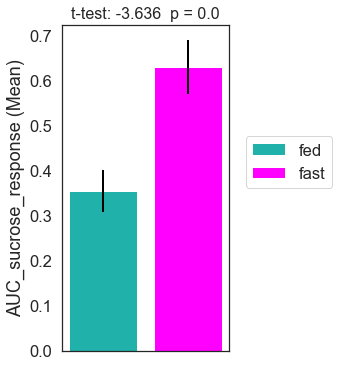

In [13]:
## Fig 6D,E: AUC bar plots ##
bar_plot(auc_condition1,auc_condition2,'AUC_sucrose_response','Sucrose',param='Mean')

In [14]:
## Do not edit - SVM classifier ##
def svm_classifier(data1, data2, split,cv):
    print '***Running SVM classifier***'
    
    parameters = [{'C': [0.001, .01,.1,1,10,100,1000], 'kernel': ['linear']},
                  {'C': [0.001, .01,.1,1,10,100,1000], 'gamma': [0.001, .01,.1,1,10,100,1000], 'kernel': ['rbf']}]
    
    # classify individual cells based on responses between two conditions (i.e., fasted vs fed) #
    if data1.shape[2]==data2.shape[2]:
        print "Cell numbers equal. Classifying within group"
        numtrials1=data1.shape[0]
        numtrials2=data2.shape[0]
        data1=data1[:,test[0]:test[1],:]
        data2=data2[:,test[0]:test[1],:]
        trialtag1=[0]*numtrials1
        trialtag2=[1]*numtrials2

        pred_score=np.nan*np.zeros((data1.shape[2]))
        rand_score=np.nan*np.zeros((data1.shape[2]))

        f = IntProgress(min=0, max=data1.shape[2], step=1, description='Progress:') # initiate progress bar
        display(f) # display the bar

        for i in range(data1.shape[2]):
            try:
                temp1=pd.DataFrame(data1[:,:,i])
                temp2=pd.DataFrame(data2[:,:,i])
                temp1['trial']=trialtag1
                temp2['trial']=trialtag2
                df=pd.concat([temp1, temp2])
                df=df.dropna(axis=0)  

                ##randomly subset df into test and train sets
                msk = np.random.rand(len(df))>split
                train = df[msk]
        #         print ('train set = ', train.shape)
                clf = GridSearchCV(SVC(), parameters,cv=cv)
                train_labels=train[['trial']].values
                c,r=train_labels.shape
                train_labels=train_labels.reshape(c,)
                clf.fit(train.iloc[:,:test[1]-test[0]], train_labels)
        #         print 'prediction accuracy = ', clf.best_score_
                pred_score[i]=(clf.best_score_)*100
                ##random array of 1s and 0s for shuffled classifier
                rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
                clf.fit(train.iloc[:,:test[1]-test[0]], rand_group[0])
        #         print 'shuffled accuracy = ', clf.best_score_
                rand_score[i]=(clf.best_score_)*100
            except:
                print "Classifier failed on cell # ",i,": n splits cannot be greater than the number of members in each class"

            f.value += 1 # signal to increment the progress bar
    
    # Choose a random subset of neurons n times and determine whether you can discriminate between conditions (e.g., LHb vs VTA projections)#
    if data1.shape[2]!=data2.shape[2]:
        n=1000
        print "Cell numbers unequal. Classifying between groups using ", str(n), "iterations"
        numneurons1=data1.shape[2]
        numneurons2=data2.shape[2]
        temp1=pd.DataFrame(np.nanmean(data1[:,test[0]:test[1],:],axis=0)).T
        temp2=pd.DataFrame(np.nanmean(data2[:,test[0]:test[1],:],axis=0)).T
        trialtag1=[0]*numneurons1
        trialtag2=[1]*numneurons2
        temp1['trial']=trialtag1
        temp2['trial']=trialtag2
        df=pd.concat([temp1, temp2])
        df=df.dropna(axis=0) 

        pred_score=np.nan*np.zeros((n))
        rand_score=np.nan*np.zeros((n))

        f = IntProgress(min=0, max=n, step=1, description='Progress:') # initiate progress bar
        display(f) # display the bar

        for i in range(n):
            try: 
                ##randomly subset df into test and train sets
                msk = np.random.rand(len(df))>split
                train = df[msk]
#                 print ('train set = ', train.shape)
                clf = GridSearchCV(SVC(), parameters,cv=cv)
                train_labels=train[['trial']].values
                c,r=train_labels.shape
                train_labels=train_labels.reshape(c,)
                clf.fit(train.iloc[:,:test[1]-test[0]], train_labels)
#                 print 'prediction accuracy = ', clf.best_score_
                pred_score[i]=(clf.best_score_)*100
                ##random array of 1s and 0s for shuffled classifier
                rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
                clf.fit(train.iloc[:,:test[1]-test[0]], rand_group[0])
#                 print 'shuffled accuracy = ', clf.best_score_
                rand_score[i]=(clf.best_score_)*100
            except:
                print "Classifier failed on cell # ",i,": n splits cannot be greater than the number of members in each class"

            f.value += 1 # signal to increment the progress bar
    
    d,p=stats.ks_2samp(pred_score,rand_score)
    plt.figure(figsize=(5,5))
    ax=plt.subplot(111)
    # n = np.arange(1,len(pred_score)+1) / np.float(len(pred_score)) #Proportion of Cells
    n=np.arange(1,len(pred_score)+1) # Number of Cells
    Xs = np.sort(pred_score)
    plt.step(Xs,n,color='g',label='Model',alpha=0.7,linewidth=2)
    # n2= np.arange(1,len(rand_score)+1) / np.float(len(rand_score)) #Proportion of Cells
    n2= np.arange(1,len(rand_score)+1) #Number of Cells
    Xs2= np.sort(rand_score)
    plt.step(Xs2,n,color='r',label='Random',alpha=0.7,linewidth=2)
    plt.xlabel('Prediction accuracy %',fontsize=20)
    plt.ylabel('Number of cells',fontsize=20)
    plt.title('K-S test Results: '+str("D={0:.7f}".format(round(d,3)))+' , '+str("p={0:.7f}".format(round(p,3))),fontsize=14)
    plt.legend(fontsize=14,loc=2)
    if save_figs[0]=='yes':
        plt.savefig('SVM/'+filename+'_split'+str(split)+'_SVM_prediction_accuracy_hist.'+fig_style, format=str(fig_style))
        np.savetxt('SVM/'+filename+'_split'+str(split)+'_SVM_prediction_accuracy.csv',pred_score,delimiter=',')
        np.savetxt('SVM/'+filename+'_split'+str(split)+'_SVM_RANDOM_prediction_accuracy.csv',rand_score,delimiter=',')
    plt.show()

    print 'Average model accuracy: ', round(np.nanmean(pred_score),2),'%'
    print 'Average random accuracy: ', round(np.nanmean(rand_score),2),'%' '\n'
    return pred_score, rand_score

In [15]:
## Fig 6G: SVM decoding##
# pred_score, rand_score = svm_classifier(extractedsignals1_norm,extractedsignals2_norm, 0.3,cv=10)

In [16]:
## DO NOT EDIT - Function to calculate number of significant neurons ##

# type of t-test ('independent','paired', or 'wilcoxon')
#p-value (two-tailed) to consider significant
def calc_sig(basedir,test_type,sig_pvalue,which_dir):
    numtrials=maxtrials   #number of trials
    baseline_dur=(baseline[1]-baseline[0])/framerate #how long is baseline (in s)
    stimulus_dur=(test[1]-test[0])/framerate  #how long is stimulus window (in s)
    trial_length=25 #how long is each trial (in s)

    ## normalize data by baseline?
#     normalize_on=['yes']
    numpreframes=35
    numtestframes=test[1]-test[0]
    numframespertrial=100
    if which_dir==1:
        print "Condition: " + condition[0]
        label=condition[0]
    elif which_dir==2:
        print "Condition: " + condition[1]
        label=condition[1]
    rewardresponse_pop = np.zeros((maxnumneurons,2));rewardresponse_pop[:]=np.nan
    avgtrace_pop = np.zeros((maxnumneurons,numframespertrial));avgtrace_pop[:] = np.nan
    sig_excited_neurons = np.zeros((maxnumneurons,1));sig_excited_neurons[:]=np.nan
    sig_inhibited_neurons = np.zeros((maxnumneurons,1));sig_inhibited_neurons[:]=np.nan
    combine_all_data=np.zeros((maxnumneurons,numframespertrial,numtrials));combine_all_data[:]=np.nan
    listdir(basedir)

    data_dirs = os.walk(basedir).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        signals=np.load(os.path.join(basedir,data_dir,lickalignfile))
        numtrials=signals.shape[0]
        signals=signals[0:numtrials,:,:]
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        reshape_response=signals

        #normalize data by baseline period
        if normalize_on[0]=='yes':
            def normalize_data(data):
                BLnorm=np.nan*np.zeros((data.shape))
                BLavg=np.nan*np.zeros((numtrials,numneurons))
                for b in range(0,numneurons):
                    for a in range(0,numtrials):
                        BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
                for e in range(0,numneurons):
                    for d in range(0,numframes):
                        for c in range(0,numtrials):
                            BLnorm[c,d,e]=data[c,d,e]-BLavg[c,e]
                reshape_response=BLnorm
                return reshape_response
            reshape_response=normalize_data(reshape_response)
        else:
            reshape_response=reshape_response   
        reshape_response=np.swapaxes(reshape_response,0,2)
        avgresponse=np.nanmean(reshape_response, axis=2)

        stimulusresponse=np.zeros((numneurons,numtrials,2));stimulusresponse[:]=np.nan
        testsig_ind=np.zeros((numneurons,2))#;stats[:]=np.nan
        testsig_paired=np.zeros((numneurons,2))#;stats[:]=np.nan
        for a in range(0,numneurons):
            avgtrace_pop[numneuronstillnow+a,:]=avgresponse[a,:]
            combine_all_data[numneuronstillnow+a,:,:numtrials]=reshape_response[a,:,:numtrials]
            for b in range(0,numtrials):
                stimulusresponse[a,b,0]=np.nanmean(reshape_response[a,test[0]:test[1],b])
                stimulusresponse[a,b,1]=np.nanmean(reshape_response[a,baseline[0]:baseline[1],b])
            if test_type=='independent':
                testsig_paired[a,:]=stats.ttest_ind(stimulusresponse[a,:,0],stimulusresponse[a,:,1],equal_var=False)
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
            if test_type=='paired':
                testsig_paired[a,:]=stats.ttest_rel(stimulusresponse[a,:,0],stimulusresponse[a,:,1])
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
            if test_type=='wilcoxon':
                testsig_paired[a,:]=stats.wilcoxon(stimulusresponse[a,:,0],stimulusresponse[a,:,1],zero_method='wilcox')
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
        sig_excited_neurons_temp=np.zeros((numneurons,1));sig_excited_neurons_temp[:]=np.nan
        sig_inhibited_neurons_temp=np.zeros((numneurons,1));sig_inhibited_neurons_temp[:]=np.nan
        
        if test_type=='wilcoxon':
            for a in range(0,numneurons):
                sig_excited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,1]<sig_pvalue,
                                                               np.nanmean(stimulusresponse[a,:,0],axis=0)>
                                                               np.nanmean(stimulusresponse[a,:,1],axis=0))
                sig_inhibited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,1]<sig_pvalue,
                                                                 np.nanmean(stimulusresponse[a,:,0],axis=0)<
                                                                 np.nanmean(stimulusresponse[a,:,1],axis=0))
        else:
            for a in range(0,numneurons):
                sig_excited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[numneuronstillnow+a,0]>0,rewardresponse_pop[numneuronstillnow+a,1]<sig_pvalue) 
                sig_inhibited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[numneuronstillnow+a,0]<0,rewardresponse_pop[numneuronstillnow+a,1]<sig_pvalue) 
#                 sig_excited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,0]>0,rewardresponse_pop[a,1]<sig_pvalue) 
#                 sig_inhibited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,0]<0,rewardresponse_pop[a,1]<sig_pvalue) 
        sig_excited_neurons[numneuronstillnow:numneuronstillnow+numneurons,:] = sig_excited_neurons_temp
        sig_inhibited_neurons[numneuronstillnow:numneuronstillnow+numneurons,:] = sig_inhibited_neurons_temp

        numneuronstillnow += numneurons 

    ind_sig_inhibited=sig_inhibited_neurons*1
    ind_sig_excited=sig_excited_neurons*1
    ind_sig_inhibited=ind_sig_inhibited[~np.isnan(ind_sig_inhibited)]
    ind_sig_excited=ind_sig_excited[~np.isnan(ind_sig_excited)]
    roinumber=np.arange(1,numneuronstillnow+1)
    ind_sig_inhibited=np.vstack((roinumber,ind_sig_inhibited))
    ind_sig_excited=np.vstack((roinumber,ind_sig_excited))
    count_sig_inhibited_neurons=np.zeros((numneuronstillnow,1));count_sig_inhibited_neurons[:]=np.nan
    count_sig_excited_neurons=np.zeros((numneuronstillnow,1));count_sig_excited_neurons[:]=np.nan

    for a in range(0,numneuronstillnow-1):
        if ind_sig_inhibited[1,a]>0:
            count_sig_inhibited_neurons[a,:]=ind_sig_inhibited[0,a]
        if ind_sig_excited[1,a]>0:
            count_sig_excited_neurons[a,:]=ind_sig_excited[0,a]

    count_sig_inhibited_neurons=count_sig_inhibited_neurons[~np.isnan(count_sig_inhibited_neurons)]
    count_sig_excited_neurons=count_sig_excited_neurons[~np.isnan(count_sig_excited_neurons)]

    find_sig_excited_neurons=np.zeros((numneuronstillnow,numframespertrial));find_sig_excited_neurons[:]=np.nan
    find_sig_inhibited_neurons=np.zeros((numneuronstillnow,numframespertrial));find_sig_inhibited_neurons[:]=np.nan
    find_sig_neurons=np.zeros(avgtrace_pop.shape);find_sig_neurons[:]=np.nan
    sig_excited_pop=np.zeros((combine_all_data.shape));sig_excited_pop[:]=np.nan
    sig_inhibited_pop=np.zeros(combine_all_data.shape);sig_inhibited_pop[:]=np.nan
    for a in range(0,numneuronstillnow):
        if sig_excited_neurons[a]==True:
            find_sig_excited_neurons[a,:]=avgtrace_pop[a,:]
            sig_excited_pop[a,:]=combine_all_data[a,:]
        if sig_inhibited_neurons[a]==True:
            find_sig_inhibited_neurons[a,:]=avgtrace_pop[a,:]  
            sig_inhibited_pop[a,:]=combine_all_data[a,:]
    mask_excited = np.all(np.isnan(find_sig_excited_neurons) | np.equal(find_sig_excited_neurons, 0), axis=1)
    plot_sig_excited_neurons=find_sig_excited_neurons[~mask_excited]
    mask_inhibited = np.all(np.isnan(find_sig_inhibited_neurons) | np.equal(find_sig_inhibited_neurons, 0), axis=1)
    plot_sig_inhibited_neurons=find_sig_inhibited_neurons[~mask_inhibited]
    mask_excited_pop = np.all(np.isnan(sig_excited_pop) | np.equal(sig_excited_pop, 0), axis=2)
    save_excited_pop=sig_excited_pop[~mask_excited_pop]
    mask_inhibited_pop = np.all(np.isnan(sig_inhibited_pop) | np.equal(sig_inhibited_pop, 0), axis=2)
    save_inhibited_pop=sig_inhibited_pop[~mask_inhibited_pop]

    peakresponse=np.zeros((numneuronstillnow,1));peakresponse[:]=np.nan
    for a in range(0,numneuronstillnow):
        peakresponse[a,:]=np.max(avgtrace_pop[a,test[0]:test[1]])
    if save_files[0]=='yes':
        np.savetxt('Sucrose/'+filename+'_Peak_Response.csv', peakresponse,delimiter=',') 
        np.save('Sucrose/'+filename+'_AVG_pop_data',avgtrace_pop)
        np.save('Sucrose/'+filename+'_pop_data',combine_all_data[:numneuronstillnow-1,:,:])
    ##plot pie chart of responses
    labels = 'No response', 'Positive\nresponse', 'Negative\nresponse'
    colors=[(0.7, 0.7,0.7),'c',(0.84, 0.35, 0.35)]
    explode=(0, .2, .2)
    frequency_population = np.zeros((3,4)) #3 response types x 4 trial types
    positiveresponders = len(count_sig_excited_neurons)
    negativeresponders = len(count_sig_inhibited_neurons)
    noresponders = numneuronstillnow-(positiveresponders+negativeresponders)
    frequency_response = np.array([noresponders, positiveresponders, negativeresponders])
    frequency_population[:,0] = frequency_response
    print "Projection: "+projection
    print "Test: "+test_type, "| P threshold: "+str(sig_pvalue)
    print "Excited = ",positiveresponders
    print "Inhibited = ",negativeresponders
    print "Null = ",noresponders
    fig8,ax1 = plt.subplots(figsize=(7,5))
    ax1.set_title(filename+' '+projection+' '+' '+label+' within condition', y=1)
    ax1.pie(frequency_response, explode=explode, autopct='%1.0f%%',
            shadow=True, startangle=45, colors=colors)
    plt.tight_layout()
    if save_figs[0]=='yes':
        plt.savefig(('Sucrose/'+filename+' '+label+'_pie_within_condition.'+fig_style), format=str(fig_style))
    plt.show()
    
    return ind_sig_excited,ind_sig_inhibited

Condition: fed
Projection: LHb
Test: paired | P threshold: 0.05
Excited =  63
Inhibited =  11
Null =  86


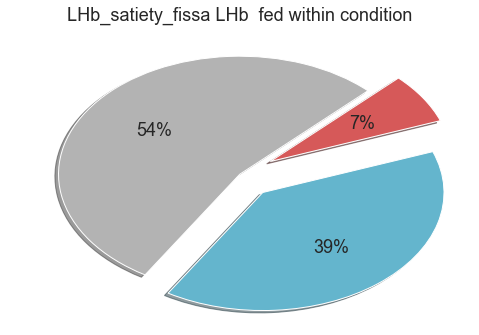

Condition: fast
Projection: LHb
Test: paired | P threshold: 0.05
Excited =  108
Inhibited =  7
Null =  45


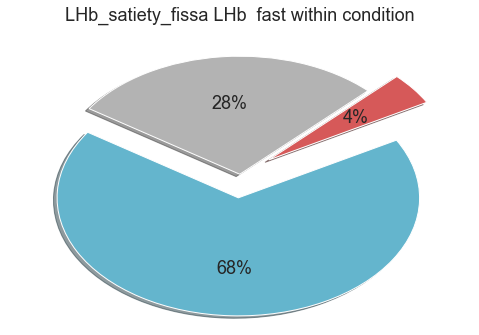

In [17]:
## Fig 6F: Percent responsive ##    
sige1,sigi1=calc_sig(basedir=basedir1,test_type='paired',sig_pvalue=0.05, which_dir=1)
sige2,sigi2=calc_sig(basedir=basedir2,test_type='paired',sig_pvalue=0.05, which_dir=2)

# Below here is the analysis for baseline data

In [18]:
## DO NOT EDIT - load baseline files ##
def loadBLfiles(basedir):
    signals_pop = np.nan*np.zeros((maxnumneurons,maxframes))
    data_dirs = os.walk(basedir).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        signals=np.load(os.path.join(basedir,data_dir,signalsfile))
        numneurons=signals.shape[1]
        numframes=signals.shape[2]
        temp_signals=np.squeeze(signals)
        for a in range(0,numneurons):
            signals_pop[numneuronstillnow+a,:maxframes]=temp_signals[a,:maxframes]
        numneuronstillnow += numneurons 
         
#         signals=np.load(os.path.join(basedir,data_dir,signalsfile))
#         numneurons=signals.shape[1]
#         numframes=signals.shape[2]
#         temp_signals=np.squeeze(signals)
#         for a in range(0,numneurons):
#             signals_pop[numneuronstillnow+a,:numframes]=temp_signals[a,:]
#         numneuronstillnow += numneurons
#         print 'File: '+str(data_dir)+'; Neurons: '+str(numneurons)
    extractedsignals=signals_pop[:numneuronstillnow,:numframes]
    numrois=extractedsignals.shape[0]
    print 'Total neurons = '+str(extractedsignals.shape[0])+'\n'
    return extractedsignals,numrois,numframes

extractedsignals1,numrois,numframes=loadBLfiles(basedir1)
extractedsignals2,numrois,numframes=loadBLfiles(basedir2)

Total neurons = 160

Total neurons = 160



In [19]:
## for plotting data, change these values
## these do not affect the output files, they are only for visualizing the events in a sample cell
roi_of_interest=1 # pick an ROI of interest
testwindow_start=1 # start frame
testwindow_stop=maxframes # End frame

In [20]:
## DO NOT EDIT - zscore BL data ##
def zscoredata(extractedsignals):
    zscore_signals=stats.zscore(extractedsignals[:,:], axis=1)
    numrois=zscore_signals.shape[0]
    numframes=zscore_signals.shape[1]
    if use_raw_data[0]=='yes':
        zscore_signals=extractedsignals
        y_axis='F/F0'
        threshold=raw_threshold
    else:
        y_axis='z-scored intensity'
        threshold=z_threshold
    #restrict frames/ROIs to values defined above
    zscore_signals=zscore_signals[:,start_frame:end_frame]
    numrois=zscore_signals.shape[0]
    numframes=zscore_signals.shape[1]
    
    #rolling mean smooth on the zscored data.
    zscore_signals_df=pd.DataFrame(zscore_signals[:,:])
    signals_smoothed=zscore_signals_df.rolling(rolling_bin, axis=1).mean()
    signals_smoothed=pd.DataFrame.as_matrix(signals_smoothed)
    print 'Number of ROIs = '+str(numrois)
    print 'Number of Frames = '+str(numframes)+'\n'
    return zscore_signals,signals_smoothed,threshold
zscore_signals1,signals_smoothed1,threshold=zscoredata(extractedsignals1)
zscore_signals2,signals_smoothed2,threshold=zscoredata(extractedsignals2)

Number of ROIs = 160
Number of Frames = 1500

Number of ROIs = 160
Number of Frames = 1500



In [21]:
## DO NOT EDIT - find 'up' and 'down' events.  up corresponds to rising edge ##
def findupdown(signals_smoothed,threshold):
    numrois=signals_smoothed.shape[0]
    numframes=signals_smoothed.shape[1]
    up=np.nan*np.empty(signals_smoothed.shape)
    down=np.nan*np.empty(signals_smoothed.shape)
    for a in range(0,numrois):
        for i in range(1,numframes-1):
            up[a,i]=signals_smoothed[a,i]>threshold and signals_smoothed[a,i-1]<threshold and signals_smoothed[a,i+1]>threshold
            down[a,i]=signals_smoothed[a,i]>threshold and signals_smoothed[a,i-1]>threshold and signals_smoothed[a,i+1]<threshold
    ## remove events if they start in up state or end in down state ##
    for a in range(numrois):
        tempup= np.argwhere(up[a,:]>0)
        tempdown= np.argwhere(down[a,:]>0)
        if tempup[0]-tempdown[0]>0:
            tempidx = np.argmax(down[a,:]>0)
            down[a,tempidx]=0
        if tempup[-1]-tempdown[-1]>0:
            tempidx = tempup[-1]
            up[a,tempidx]=0
    return up, down
up1,down1=findupdown(signals_smoothed1,threshold)
up2,down2=findupdown(signals_smoothed2,threshold)

In [22]:
## DO NOT EDIT - Function to plot ts with unfiltered event borders overlayed in red and export (if plot_traces = yes) ##
def plottswithevents(signals_smoothed,up,down,threshold,label):
    if plot_traces[0]=='yes':
        uptimesthreshold=up*threshold
        downtimesthreshold=down*threshold
        uptimesthreshold[uptimesthreshold==0]=np.nan
        downtimesthreshold[downtimesthreshold==0]=np.nan    
        for a in range(0,numrois):
            fig,ax = plt.subplots(1)
            sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
            sns.tsplot(signals_smoothed[a,start_frame:end_frame])
            sns.tsplot(downtimesthreshold[a,start_frame:end_frame], color='r', interpolate=False)
            sns.tsplot(uptimesthreshold[a,start_frame:end_frame], color='k', interpolate=False)
            plt.xlabel('Frames', fontsize=20)
            plt.ylabel('z-score', fontsize=20)
            plt.title('ROI numer '+str(a)+' '+condition[label], fontsize=20)
            fig.tight_layout(w_pad=5)
            if save_figs[0]=='yes':
                fig.savefig(('BL/'+filename+'_'+condition[label]+'_BLevents_unfiltered_ROI_'+str(a)+'.'+fig_style), format=str(fig_style))
                plt.show()
            fig.clf()
plottswithevents(signals_smoothed1,up1,down1,threshold,label=0)
plottswithevents(signals_smoothed2,up2,down2,threshold,label=1)

In [23]:
## DO NOT EDIT - find events ##
def find_events(signals_smoothed,up,down,label):
    numrois=signals_smoothed.shape[0]
    down=down*-1
    combined=up+down #values of 1 indicates rise and -1 indicates fall
    #append frame number to array
    time=np.arange(maxframes)
    zscore_signals_temp=np.squeeze(signals_smoothed)
    signals_with_time=np.vstack((zscore_signals_temp, time)) 
    signals_with_time[-1,:]

    #find frame number of 'up' and 'down' events.  Up corresponds to rising edge, down=falling edge
    diff_down=np.nan*np.empty(signals_with_time.shape)
    diff_up=np.nan*np.empty(signals_with_time.shape)
    for a in range(0,numrois):
        for i in range(0,maxframes):
            if combined[a,i]<0:
                diff_down[a,i]=signals_with_time[-1,i]
            if combined[a,i]>0:
                diff_up[a,i]=signals_with_time[-1,i]
    temp_up=np.nan*np.empty([signals_with_time.shape[1],2])
    temp_down=np.nan*np.empty([signals_with_time.shape[1],2])
    event_time=np.NAN*np.ones(signals_with_time.shape)
    allevents=np.NAN*np.ones(signals_with_time.shape)
    allareas=np.NAN*np.ones(signals_with_time.shape)
    allpeak=np.NAN*np.ones(signals_with_time.shape)

    for a in range(0,numrois):
        temp_up[:,0]=diff_up[a,:]
        temp_down[:,1]=diff_down[a,:]
        temp_up2=temp_up[~np.isnan(temp_up)]
        temp_down2 = temp_down[~np.isnan(temp_down)]
        event_time=temp_down2-temp_up2
        for q in range (0,event_time.shape[0]):
            area=np.NAN*np.ones(event_time.shape[0])
            placehold_frames=signals_smoothed[a,int(temp_up2[q]):int(temp_down2[q])]
            peak=np.max(placehold_frames)
            area=np.trapz(placehold_frames)#, x=None, dx=1)#, axis=-1)   
            allareas[a,q] = area 
            allpeak[a,q] = peak
        allevents[a,:event_time.shape[0]] = event_time
    allevents=allevents/framerate
    count_events=~np.isnan(allevents)
    count_events=np.sum(count_events,axis=1);count_events=count_events[0:count_events.shape[0]-1]
    
    ##find event times and export inter-event intervals
    combine_time=np.vstack((up,time))
    for a in range(0,numrois):
        for b in range(0,maxframes):
            if combined[a,b]==1:
                combine_time[a,b]=combine_time[-1,b]
    event_time=np.nan*np.zeros((combined.shape))
    event_iei=np.nan*np.zeros((combined.shape))
    combine_time[combine_time==0]=np.nan
    for a in range(0,numrois):
        temp_time=combine_time[a,:]
        temp_time=temp_time[~np.isnan(temp_time)]
        temp_iei=np.diff(temp_time)
        event_time[a,0:temp_time.shape[0]]=temp_time
        event_iei[a,0:temp_iei.shape[0]]=temp_iei
    event_iei=event_iei/framerate
    
    if save_files[0]=='yes':
        np.save('BL/'+filename+'_BLevent_frames_'+condition[label],event_time)
        np.save('BL/'+filename+'_BLevent_iei_'+condition[label],event_iei)
        np.save('BL/'+filename+'_BLevent_dur_'+condition[label], allevents)
        np.save('BL/'+filename+'_BLevent_AUC_'+condition[label], allareas)
        np.save('BL/'+filename+'_BLevent_peak_amplitude_'+condition[label], allpeak)
    return count_events, allevents, allareas, allpeak, event_iei,event_time

count_events1, alldurs1, allareas1, allpeak1, iei1,event_time1=find_events(signals_smoothed1,up1,down1,label=0)
count_events2, alldurs2, allareas2, allpeak2, iei2,event_time2=find_events(signals_smoothed2,up2,down2,label=1)

In [24]:
## DO NOT EDIT - Function to filter data based on thresholds defined above ##
def filter_data(alldurs,allareas,allpeak,iei,event_time,label):
    durfilt=np.nan*np.zeros((alldurs.shape))
    areafilt=np.nan*np.zeros((allareas.shape))
    peakfilt=np.nan*np.zeros((allpeak.shape))
    ieifilt=np.nan*np.zeros((iei.shape))
    
    ## Filter data by duration threshold ##
    for a in range(alldurs.shape[0]):
        temp=alldurs[a,:]
        temp=temp>timethreshold
        tempdur=alldurs[a,temp]
        temppeak=allpeak[a,temp]
        temparea=allareas[a,temp]
        durfilt[a,:len(tempdur)]=tempdur
        areafilt[a,:len(temparea)]=temparea
        peakfilt[a,:len(temppeak)]=temppeak
    for a in range(alldurs.shape[0]-1):
        temp=alldurs[a,:]
        temp=temp>timethreshold
        tempiei=iei[a,temp]
        ieifilt[a,:len(tempiei)]=tempiei
    if save_files[0]=='yes':
        np.save('BL/'+filename+'_BLevent_peak_amp_filt_'+condition[label], peakfilt)
        np.save('BL/'+filename+'_BLevent_auc_filt_'+condition[label],areafilt)
        np.save('BL/'+filename+'_BLevent_iei_filt_'+condition[label],ieifilt)
        np.save('BL/'+filename+'_BLevent_dur_filt_'+condition[label],durfilt)
    return durfilt, areafilt, peakfilt, ieifilt

durfilt1, areafilt1, peakfilt1, ieifilt1=filter_data(alldurs1, allareas1,allpeak1,iei1,event_time1,label=0)
durfilt2, areafilt2, peakfilt2, ieifilt2=filter_data(alldurs2, allareas2,allpeak2,iei2,event_time2,label=1)

In [25]:
# ## plot histograms for filtered data condition 1 ##
# plot_histogram(durfilt1,50,0,10,'Event Durations (Filtered)','Event Duration (s)','green',label=0)
# plot_histogram(areafilt1,50,0,50,'Event Areas (Filtered)','Event AUC','red',label=0)
# plot_histogram(peakfilt1,50,0,6,'Peak Amplitudes (Filtered)','Event Amplitude','blue',label=0)
# plot_histogram(ieifilt1,50,0,150,'Inter-event Intervals (Filtered)','Inter-event Interval (s)','k',label=0)

# ## plot histograms for filtered data condition 2 ##
# plot_histogram(durfilt2,50,0,10,'Event Durations (Filtered)','Event Duration (s)','green',label=1)
# plot_histogram(areafilt2,50,0,50,'Event Areas (Filtered)','Event AUC','red',label=1)
# plot_histogram(peakfilt2,50,0,6,'Peak Amplitudes (Filtered)','Event Amplitude','blue',label=1)
# plot_histogram(ieifilt2,50,0,150,'Inter-event Intervals (Filtered)','Inter-event Interval (s)','k',label=1)

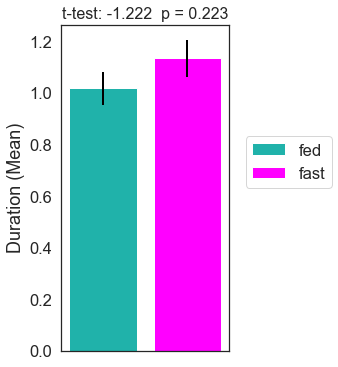

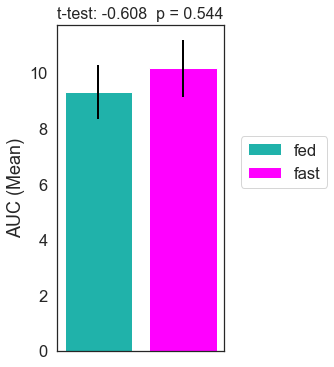

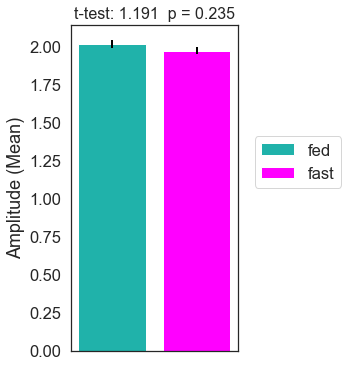

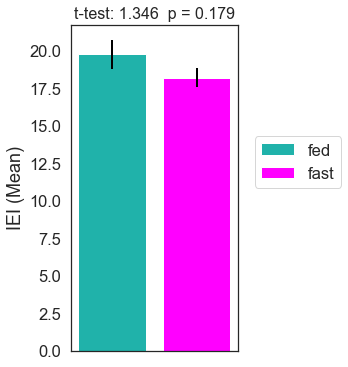

In [26]:
## Plot bar graphs to compare event properties ##
## Unfiltered ##    
bar_plot(alldurs1,alldurs2,'Duration','BL',param='Mean')
bar_plot(allareas1,allareas2,'AUC','BL',param='Mean')
bar_plot(allpeak1,allpeak2,'Amplitude','BL',param='Mean')
bar_plot(iei1,iei2,'IEI','BL',param='Mean')

# Plot two example neurons:

In [27]:
## function to plot single neuron data ##
plotfont=20
sns.set(font_scale=2)
size=[5,15]

def plot_single_neurons(sucdata, quindata, condition, roinum,projection):
    i=roinum
    ## normalize data by baseline period ##
    def normalize_data(data):
        BLnorm=np.nan*np.zeros((data.shape))
        BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
        for b in range(0,data.shape[2]):
            for a in range(0,data.shape[0]):
                BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        for e in range(0,data.shape[2]):
            for d in range(0,data.shape[1]):
                for c in range(0,data.shape[0]):
                    BLnorm[c,d,e]=data[c,d,e]/BLavg[c,e]
        reshape_response=BLnorm
        return reshape_response
    sucnorm=normalize_data(sucdata)
    quinnorm=normalize_data(quindata)
    
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    plt.clf()
    fig4 = plt.figure(4)
    fig4.set_figheight(size[0])
    fig4.set_figwidth(size[1])
    ax1 = plt.subplot(121)
    ax1=sns.heatmap(sucnorm[:,:,i], linewidth=0, cmap=cmap, vmin=.8, vmax=1.2, cbar_kws={'label': 'dF/F'},rasterized=True)
    trial_len=sucnorm.shape[0]
    ax1.set_title(projection+' ROI_'+str(i)+' '+condition[0], fontsize=plotfont)
    ax1.set_xlabel('Time from lick (s)',fontsize=plotfont)
    ax1.set_xticks(range(5, framespertrial+1, 10))
    ax1.set_xticklabels([str(((a-(baseline[1]-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize=plotfont)
    ax1.set_yticks(range(0, trial_len, 10))
    ax1.set_yticklabels([str(b) for b in range(trial_len, 0, -10)],fontsize=plotfont)
    ax1.plot([baseline[1], baseline[1]], [0, trial_len], '--w', linewidth=3)
    ax1.set_ylabel('Trial number',fontsize=plotfont)

    fig5 = plt.figure(4)
    ax2 = plt.subplot(122)
    fig5.set_figheight(size[0])
    fig5.set_figwidth(size[1])
    ax2=sns.heatmap(quinnorm[:,:,i], linewidth=0, cmap=cmap, vmin=.8, vmax=1.2, cbar_kws={'label': 'dF/F'},rasterized=True)
    trial_len=quinnorm.shape[0]
    ax2.set_title(projection+' ROI_'+str(i)+' '+condition[1], fontsize=plotfont)
    ax2.set_xlabel('Time from lick (s)',fontsize=plotfont)
    ax2.set_xticks(range(5, framespertrial+1, 10))
    ax2.set_xticklabels([str(((a-(baseline[1]-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize=plotfont)
    ax2.set_yticks(range(0, trial_len, 10))
    ax2.set_yticklabels([str(b) for b in range(trial_len, 0, -10)],fontsize=plotfont)
    ax2.plot([baseline[1], baseline[1]], [0, trial_len], '--w', linewidth=3)
    ax2.set_ylabel('Trial number',fontsize=plotfont)
    
    fig5.tight_layout(w_pad=2)
    if save_files[0]=='yes':
        plt.savefig((filename+'_'+projection+'_ROI_'+str(i)+'.pdf'), format='pdf')
        plt.show()
    else:
        plt.show()
        
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    fig7 = plt.figure(4)
    ax3 = plt.subplot(211)
    fig7.set_figheight(size[0]*2)
    fig7.set_figwidth(size[0]*2)
    ax3=sns.tsplot(np.nanmean(sucnorm[:,:,i],axis=0),linewidth=3,color='blue')
    ax3=sns.tsplot(np.nanmean(quinnorm[:,:,i],axis=0),linewidth=3,color='red')
    h = plt.gca().get_lines()
    plt.legend(handles=h, labels=condition,fontsize=20)
    ax3.set_title(filename+'_'+projection+'_ROI_'+str(i), fontsize=plotfont)
    ax3.set_xlabel('Time from lick (s)', fontsize=plotfont, labelpad=3)
    ax3.set_xticks(range(5, framespertrial+1, 10))
    ax3.set_xticklabels([str(((a-(baseline[1]-baseline[0])+5)/framerate)) for a in range(0, 
            framespertrial+1, 10)],fontsize=plotfont)
    plt.xticks(fontsize=plotfont)
    plt.yticks(fontsize=plotfont)
    plt.ylim([(np.min([np.nanmean(sucnorm[:,:,i],axis=0),np.nanmean(quinnorm[:,:,i],axis=0)])-.1),
              (np.max([np.nanmean(sucnorm[:,:,i],axis=0),np.nanmean(quinnorm[:,:,i],axis=0)])+.1)])
    plt.ylabel('dF/F', fontsize=plotfont)
    ax3.plot([baseline[1], baseline[1]],
             [(np.min([np.nanmean(sucnorm[:,:,i],axis=0),np.nanmean(quinnorm[:,:,i],axis=0)])-.1),
              (np.max([np.nanmean(sucnorm[:,:,i],axis=0),np.nanmean(quinnorm[:,:,i],axis=0)])+.1)], '--k', linewidth=2)
    plt.axhline(y=1, linestyle='--', linewidth=2, color='k')
    if save_files[0]=='yes':
        plt.savefig((filename+'_'+projection+'_ROI_'+str(i)+'_AVG.pdf'), format='pdf')
        plt.show()
    else:
        plt.show()

<Figure size 432x288 with 0 Axes>

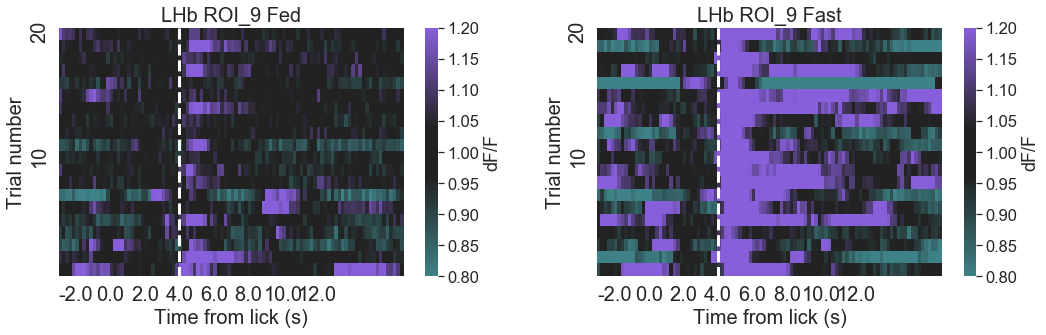

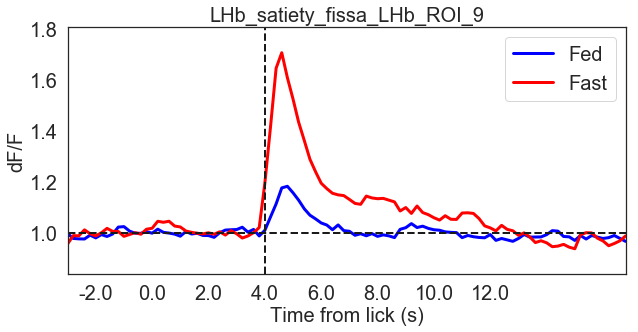

In [28]:
## Fig 6B: LHb example neuron ##
fedroi=np.load("\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\LHb\\fed\\AH10\\TRACKED_fissa_lick_align.npy")
fastroi=np.load("\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\LHb\\fast\\AH10\\TRACKED_fissa_lick_align.npy")

plot_single_neurons(sucdata=fedroi, quindata=fastroi, condition=["Fed", "Fast"],roinum=9,projection='LHb')

<Figure size 432x288 with 0 Axes>

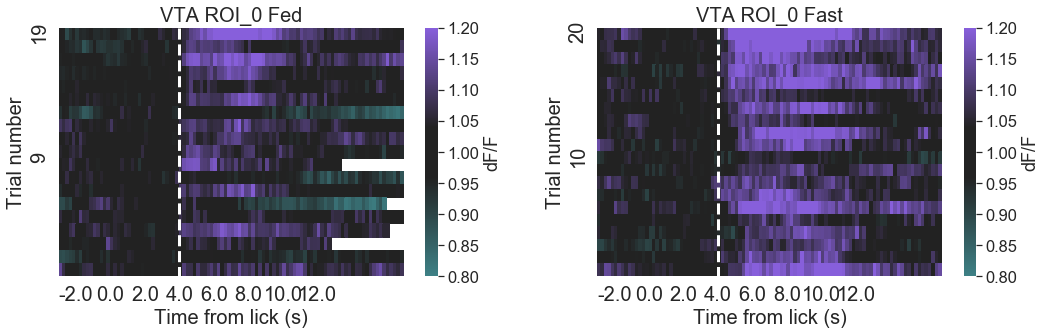

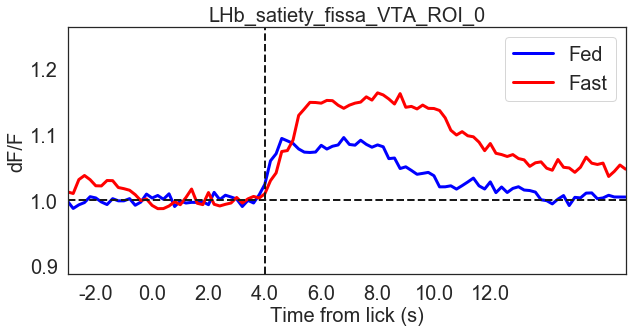

In [29]:
## Fig 6B: VTA example neuron ##
fedroi=np.load("\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\VTA\\fed\\AH14\\TRACKED_fissa_lick_align.npy")
fastroi=np.load("\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\VTA\\fast\\AH14\\TRACKED_fissa_lick_align.npy")

plot_single_neurons(sucdata=fedroi, quindata=fastroi, condition=["Fed", "Fast"],roinum=0,projection='VTA')

# Correlate lick rate with neural activity

In [30]:
## function to correlate activity with lick rate ##
framerate=5
maxtrials=60    #number of trials
framespertrial=100
numpreframes=35
baseline=[20,35]
test=[35,65]
min_bout_pause = 300 ## duration in ms to define the pause to indicate the end of a bout of licking

## parse licks and return correlation data
def getlicks(basedir):
    alltrials=0
    totalneurons=0
    filecount=0
    alllickrate=np.nan*np.zeros((maxnumneurons,framespertrial))

    corr_pop_max = np.nan*np.zeros((maxnumneurons,2))
    corr_pop_mean = np.nan*np.zeros((maxnumneurons,2))
    
    data_dirs = os.walk(basedir).next()[1]
    licktotal=np.nan*np.zeros((len(data_dirs))) ; q=0
    for data_dir in data_dirs:
        try:
            behaviordata=sio.loadmat(os.path.join(basedir,data_dir,'behavior.mat'))
            signals=np.load(os.path.join(basedir,data_dir,lickalignfile))
            numneurons=signals.shape[2]
        except:
            continue
        cues=np.squeeze(behaviordata['cues'])
        licks=np.squeeze(behaviordata['licks'])
        t_fxd=np.squeeze(behaviordata['fxdpumps'])#/1000 #in seconds
        eventlog = behaviordata['eventlog']
        tempframes = eventlog[eventlog[:,0]==9,1]
        sucrose = eventlog[eventlog[:,0]==5,1]+3000 #Add 3s to account for time between "cue" timestamp and liquid delivery
        quinine = eventlog[eventlog[:,0]==6,1]+3000 #Add 3s to account for time between "cue" timestamp and liquid delivery
        frameaveraging = 6
        framerate = 30.0/frameaveraging #for resonant scanner, maximum rate is 30Hz
        frames = tempframes[::frameaveraging]
        cuesplus=cues[cues>0]
        
        def findfirstlick(data):
            firstlick=np.nan*np.zeros((len(data)))
            for a in range(0,len(data)):
                try:
                    if data[a]-licks[licks>data[a]][1] < -10000:
                        firstlick[a] = np.nan
                    elif data[a]-licks[licks>data[a]][0] == -51:
                        firstlick[a] = licks[licks>data[a]][1] #use second lick to avoid solenoid artifact
                    else:
                        firstlick[a] = licks[licks>data[a]][1] #use second lick to avoid solenoid artifact
                except:
                    pass
            return firstlick
        firstlickafterCSplus=findfirstlick(t_fxd)
        
        ## calculate latency to lick after reward delivery
        def get_lick_latency(lick,event):
            latency=np.nan*np.zeros((lick.shape))
            for i in range(len(event)):
                temp=(lick[i]-event[i])/1000
                if temp<10:
                    latency[i]=temp
            latency=latency[~np.isnan(latency)]
            return latency
        latencyall=get_lick_latency(firstlickafterCSplus,t_fxd)

        ##find frame numbers
        def framenumberforevent(event):
            framenumber = np.nan*np.zeros(event.shape)
            for ie, e in enumerate(event):
                try:
                    framenumber[ie] = np.nonzero(frames<=e)[0][-1]
                except:
                    pass
            return framenumber
        framenumberforcuesplus = np.squeeze(framenumberforevent(cuesplus))
        framenumberforlicks = np.squeeze(framenumberforevent(licks))
        framenumberforCSpluslick = np.squeeze(framenumberforevent(firstlickafterCSplus))
        framenumberforrew=np.squeeze(framenumberforevent(t_fxd))
        framenumberforCSpluslick=framenumberforCSpluslick[~np.isnan(framenumberforCSpluslick)]
            
        def alignlickbehav(event):
            eventnum=event.shape[0]
            lickframes=np.zeros((t_fxd.shape[0]*125))
            lickframesrate=np.zeros((t_fxd.shape[0]*125))
            framesall=np.arange(0,lickframes.shape[0])
            numtimesampleslick = 100 #How many do you want to plot around the cue?
            for a in range(0,len(framesall)):
                for b in range(0,len(framenumberforlicks)):
                    if framenumberforlicks[b]==framesall[a]:
                        lickframes[a]=1 
                        lickframesrate[a]=lickframesrate[a]+1
            lickframesrate=lickframesrate*framerate
            alignlick_behavior = np.zeros([eventnum,framespertrial]) #for lick probability lick aligned
            alignlick_rate = np.zeros([eventnum,framespertrial]) #for lick rate lick aligned
            for i in range(event.shape[0]):
                try:
                    alignlick_behavior[i,:]= lickframes[int(event[i]-baseline[0]):int(event[i]+numtimesampleslick-baseline[0])]
                    alignlick_rate[i,:]= lickframesrate[int(event[i]-baseline[0]):int(event[i]+numtimesampleslick-baseline[0])]
                except:
                    templen=lickframes[int(event[i]-baseline[0]):].shape[0]
                    alignlick_behavior[i,:templen]= lickframes[int(event[i]-baseline[0]):]
                    alignlick_rate[i,:templen]= lickframesrate[int(event[i]-baseline[0]):]
            return alignlick_behavior, alignlick_rate                    

        alltrialsprob, alltrialsrate= alignlickbehav(framenumberforCSpluslick)
        alllickrate[alltrials:alltrials+framenumberforCSpluslick.shape[0],:]=alltrialsrate[:,:]
        sumlicks=np.nansum(alltrialsrate[:,test[0]:test[1]],axis=1)

        ## perform pearson correlation on lick and activity data within 'test' range #
        for a in range(0,numneurons):
            temp=signals[:,test[0]:test[1],a]
            tempmax=np.nanmax(temp,axis=1)
            tempmean=np.nanmean(temp,axis=1)
            tempcat=np.column_stack((tempmax,tempmean,sumlicks))
            tempcat=tempcat[~np.isnan(tempcat).any(axis=1)]
            
            rmax,pmax=stats.pearsonr(tempcat[:,0],tempcat[:,2])
            rmean,pmean=stats.pearsonr(tempcat[:,1],tempcat[:,2])
            corr_pop_max[totalneurons+a,0]=rmax
            corr_pop_max[totalneurons+a,1]=pmax
            corr_pop_mean[totalneurons+a,0]=rmean
            corr_pop_mean[totalneurons+a,1]=pmean
        
        alltrials += alltrialsrate.shape[0]
        totalneurons += numneurons
        filecount+=1
        
    single_cell_corr_max=corr_pop_max[:totalneurons,:]
    single_cell_corr_mean=corr_pop_mean[:totalneurons,:]
    alllickrate=alllickrate[:alltrials,:] 
    return alllickrate,  single_cell_corr_max, single_cell_corr_mean   

In [31]:
## Fig S5D-G: Correlate activity with licking ##
alllickrate1, single_cell_corr_max1,single_cell_corr_mean1 =getlicks(basedir1)
alllickrate2, single_cell_corr_max2,single_cell_corr_mean2 =getlicks(basedir2)

np.savetxt(filename+'_'+condition[0]+'_MeanActivity_v_LickRate_Corr.csv',single_cell_corr_mean1,delimiter=',')
np.savetxt(filename+'_'+condition[1]+'_MeanActivity_v_LickRate_Corr.csv',single_cell_corr_mean2,delimiter=',')

# Plot licking data

In [32]:
## IMPORTANT! dir1 and dir2 should be 'fed' and dir3/dir4 'fast' - Set filepaths and trial info ##
## 
dir1 = "\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\LHb\\fed"
dir2 = "\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\VTA\\fed"

dir3="\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\LHb\\fast"
dir4="\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig6 satiety\\VTA\\fast"

save_location="\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\FigS5 satiety imaging supp"

filename='combined_projections_behavior' ## name to be appended to saved files/figs

maxnumneurons = 1000 #used to initialize arrays. Should be larger than the total number of neurons
framespertrial=80 #frames per trial in lick align file
maxtrials=20
baseline=[20,35]#baseline window in frames
numpreframes=35 #frames before first lick
framerate=5
# colors = ['lightseagreen','indigo']
colors=['darkorange','darkgreen']
fig_style='pdf' ##png, pdf, tif

In [33]:
## DO NOT EDIT - Function to align lick data to first lick after reward and plot ##
def align_licks(basedir):  
    numtrialstillnow=0
    alllickdata=np.nan*np.zeros((maxnumneurons,framespertrial))
    alllickdatarate=np.nan*np.zeros((maxnumneurons,framespertrial))
    alllickdatarew=np.nan*np.zeros((maxnumneurons,framespertrial))
    alllickdatarewrate=np.nan*np.zeros((maxnumneurons,framespertrial))
    latency=np.nan*np.zeros((maxnumneurons))
    data_dirs = os.walk(basedir).next()[1]
    licktotal=np.nan*np.zeros((len(data_dirs))) ; q=0
    for data_dir in data_dirs:
        try:
            behaviordata=sio.loadmat(os.path.join(basedir,data_dir,'behavior.mat'))
        except:
            continue
        cues=np.squeeze(behaviordata['cues'])
        licks=np.squeeze(behaviordata['licks'])
        t_fxd=np.squeeze(behaviordata['fxdpumps'])#/1000 #in seconds
        eventlog = behaviordata['eventlog']
        tempframes = eventlog[eventlog[:,0]==9,1]
        frameaveraging = 6
        framerate = 30.0/frameaveraging #for resonant scanner, maximum rate is 30Hz
        frames = tempframes[::frameaveraging]
        cuesplus=cues[cues>0]
        
        ## calculate first lick after reward. limit to licks occurring within 15s of rew delivery. 
        firstlickafterCSplus=np.nan*np.zeros((len(t_fxd)))
        for a in range(0,len(t_fxd)):
            try:
                if t_fxd[a]-licks[licks>t_fxd[a]][1] < -10000:
                    firstlickafterCSplus[a] = np.nan
                elif t_fxd[a]-licks[licks>t_fxd[a]][0] == -51:
                    firstlickafterCSplus[a] = licks[licks>t_fxd[a]][1] #use second lick to avoid solenoid artifact
                else:
                    firstlickafterCSplus[a] = licks[licks>t_fxd[a]][1] #use second lick to avoid solenoid artifact
            except:
                firstlickafterCSplus[a]=np.nan
        
        ## remove lick artifact from 'licks' ##
        removelicks=np.nan*np.zeros((0))
        for a in range(len(t_fxd)):
            templicks=licks[np.logical_and(licks>t_fxd[a], licks<firstlickafterCSplus[a])]
            removelicks=np.append(removelicks, templicks)
        licks=licks[~np.isin(licks,removelicks)]
        licktotal[q]=len(licks) ; q+=1
        
        ## calculate latency to lick after reward delivery
        latency_temp=np.nan*np.zeros((maxtrials))
        for i in range(len(t_fxd)):
            latency_temp[i]=(firstlickafterCSplus[i]-t_fxd[i])/1000
   
        ##find frame numbers
        def framenumberforevent(event):
            framenumber = np.nan*np.zeros(event.shape)
            for ie, e in enumerate(event):
                try:
                    framenumber[ie] = np.nonzero(frames<=e)[0][-1]
                except:
                    pass
            return framenumber
        framenumberforcuesplus = np.squeeze(framenumberforevent(cuesplus))
        framenumberforlicks = np.squeeze(framenumberforevent(licks))
        framenumberforCSpluslick = np.squeeze(framenumberforevent(firstlickafterCSplus))
        framenumberforrew=np.squeeze(framenumberforevent(t_fxd))
        framenumberforCSpluslick=framenumberforCSpluslick[~np.isnan(framenumberforCSpluslick)]
        lickframes=np.zeros((maxtrials*125))
        lickframesrate=np.zeros((maxtrials*125))
        framesall=np.arange(0,lickframes.shape[0])
        numtimesampleslick = 80 #How many do you want to plot around the cue?
        
        for a in range(0,len(framesall)):
            for b in range(0,len(framenumberforlicks)):
                if framenumberforlicks[b]==framesall[a]:
                    lickframes[a]=1 
                    lickframesrate[a]=lickframesrate[a]+1
        lickframesrate=lickframesrate*framerate
        alignlick_behavior = np.zeros([maxtrials,framespertrial]) #for lick probability lick aligned
        alignlick_rate = np.zeros([maxtrials,framespertrial]) #for lick rate lick aligned
        alignlick_rew=np.zeros([maxtrials,framespertrial]) #for lick probability reward aligned
        alignlick_rewrate=np.zeros([maxtrials,framespertrial]) #for lick rate reward aligned

        for i in range(framenumberforCSpluslick.shape[0]):
            try:
                alignlick_behavior[i,:]= lickframes[int(framenumberforCSpluslick[i]-baseline[0]):int(framenumberforCSpluslick[i]+numtimesampleslick-baseline[0])]
                alignlick_rate[i,:]= lickframesrate[int(framenumberforCSpluslick[i]-baseline[0]):int(framenumberforCSpluslick[i]+numtimesampleslick-baseline[0])]
                alignlick_rew[i,:]= lickframes[int(framenumberforrew[i]-baseline[0]):int(framenumberforrew[i]+numtimesampleslick-baseline[0])]
                alignlick_rewrate[i,:]= lickframesrate[int(framenumberforrew[i]-baseline[0]):int(framenumberforrew[i]+numtimesampleslick-baseline[0])]
            except:
                templen=lickframes[int(framenumberforCSpluslick[i]-baseline[0]):].shape[0]
                alignlick_behavior[i,:templen]= lickframes[int(framenumberforCSpluslick[i]-baseline[0]):]
                alignlick_rate[i,:templen]= lickframesrate[int(framenumberforCSpluslick[i]-baseline[0]):]

        numtrialstillnow += maxtrials
    
        alllickdata[numtrialstillnow-maxtrials:numtrialstillnow,:]=alignlick_behavior[:,:]
        alllickdatarate[numtrialstillnow-maxtrials:numtrialstillnow,:]=alignlick_rate[:,:]
        alllickdatarew[numtrialstillnow-maxtrials:numtrialstillnow,:]=alignlick_rew[:,:]
        alllickdatarewrate[numtrialstillnow-maxtrials:numtrialstillnow,:]=alignlick_rewrate[:,:]
        latency[numtrialstillnow-maxtrials:numtrialstillnow]=latency_temp
    
    latency=latency[:numtrialstillnow];latency=latency[~np.isnan(latency)]
    alllickdata=alllickdata[:numtrialstillnow,:]
    alllickdatarew=alllickdatarew[:numtrialstillnow,:]
    alllickdatarate=alllickdatarate[:numtrialstillnow,:]
    alllickdatarewrate=alllickdatarewrate[:numtrialstillnow,:]
    return alllickdata,alllickdatarew,latency,licktotal,alllickdatarate,alllickdatarewrate  

In [34]:
## get data ##
alignlicks1,rewalignlicks1,latency1,licktotal1,alignlickrate1,rewalignrate1=align_licks(dir1)
alignlicks2,rewalignlicks2,latency2,licktotal2,alignlickrate2,rewalignrate2=align_licks(dir2)

alignlicks3,rewalignlicks3,latency3,licktotal3,alignlickrate3,rewalignrate3=align_licks(dir3)
alignlicks4,rewalignlicks4,latency4,licktotal4,alignlickrate4,rewalignrate4=align_licks(dir4)

In [35]:
## combine dir1&dir2 and dir3&dir4 data 
combined_alignlicks1=np.concatenate((alignlicks1,alignlicks2),axis=0)
combined_alignlicks2=np.concatenate((alignlicks2,alignlicks3),axis=0)

combined_rewalignlicks1=np.concatenate((rewalignlicks1,rewalignlicks2),axis=0)
combined_rewalignlicks2=np.concatenate((rewalignlicks3,rewalignlicks4),axis=0)

combined_latency1=np.concatenate((latency1,latency2))
combined_latency2=np.concatenate((latency3,latency4))

combined_licktotal1=np.concatenate((licktotal1,licktotal2))
combined_licktotal2=np.concatenate((licktotal3,licktotal4))

combined_alignlickrate1=np.concatenate((alignlickrate1,alignlickrate2),axis=0)
combined_alignlickrate2=np.concatenate((alignlickrate3,alignlickrate3),axis=0)

combined_rewalignrate1=np.concatenate((rewalignrate1,rewalignrate2),axis=0)
combined_rewalignrate2=np.concatenate((rewalignrate3,rewalignrate4),axis=0)

In [36]:
## DO NOT EDIT - Funciton to plot overlayed lick data ##
def plotlickdata(data1,data2,xtitle,ylim,ylabel,condition):
    fontsize=20
    sns.set(font_scale=1.5,style="white",rc={"lines.linewidth": 1})
    sns.set_style("ticks", {"xtick.major.size": 0, "ytick.major.size": 8})
    f,ax = plt.subplots(1,1,figsize=(10,5))
    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    sns.tsplot(data1[:,:], color=colors[0], condition=condition[0], legend=True)
    sns.tsplot(data2[:,:], color=colors[1], condition=condition[1], legend=True)
    ax.set_title(filename+' lick rate',fontsize=fontsize)
    ax.set_xlabel(xtitle+' (s)',fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_yticks(np.arange(ylim[0],ylim[1]+1,ylim[1]/2))
    ax.set_yticklabels(np.arange(ylim[0],ylim[1]+1,ylim[1]/2),fontsize=fontsize)
    ax.set_xticks(range(10, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize=fontsize)
    ax.set_ylim([ylim[0],ylim[1]+.05])
    f.tight_layout(w_pad=5)
    plt.savefig((filename+'_'+xtitle+'_'+ylabel+'.'+fig_style), format=str(fig_style))
    plt.show()

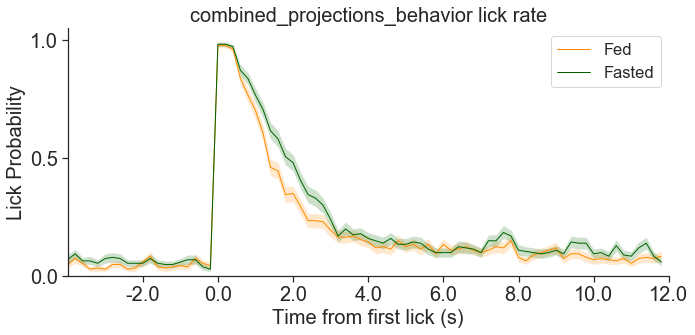

In [37]:
plotlickdata(combined_alignlicks1,combined_alignlicks2,'Time from first lick',ylim=[0,1],ylabel='Lick Probability',condition=['Fed','Fasted'])

In [38]:
## DO NOT EDIT - Function to plot bars to compare conditions ##
def bar_plot(data1,data2,ytitle,param,condition):
    savedata=np.nan*np.zeros((max(data1.shape[0],data2.shape[0]),2))
    savedata[:data1.shape[0],0]=data1
    savedata[:data2.shape[0],1]=data2
    if param=='Median':
        try:
            if data1.shape[1]>0:
                data1=np.nanmedian(data1,axis=1)
                data1=data1[~np.isnan(data1)]
                data2=np.nanmedian(data2,axis=1)
                data2=data2[~np.isnan(data2)]
        except:
            pass
        means=np.nan*np.zeros((1,2))
        means[:,0]=np.nanmedian(data1)
        means[:,1]=np.nanmedian(data2)
        means=np.squeeze(means)
        try:
            t,p=np.around(stats.wilcoxon(data1,data2),decimals=3)
            test='Wilcoxon Rank Sum'
        except:
            t,p=np.around(stats.ttest_ind(data1,data2),decimals=3)
            test='t-test'
        sems=np.nan*np.zeros((1,2))
        sems[:,0]= stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)

    else:
        test='t-test'
        try:
            if data1.shape[1]>0:
                data1=np.nanmean(data1,axis=1)
                data1=data1[~np.isnan(data1)]
                data2=np.nanmean(data2,axis=1)
                data2=data2[~np.isnan(data2)]
        except:
            pass
        means=np.nan*np.zeros((1,2))
        means[:,0]=np.nanmean(data1)
        means[:,1]=np.nanmean(data2)
        means=np.squeeze(means)
        t,p=np.around(stats.ttest_ind(data1,data2),decimals=3)
        sems=np.nan*np.zeros((1,2))
        sems[:,0]=stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)
    np.savetxt(ytitle+'.csv',savedata,delimiter=',')
    ind = (0,.5)
    width = 0.4
    fig,ax=plt.subplots(1,figsize=(3,6))
    bar=ax.bar(ind,means,width,yerr=sems,color=colors,error_kw={'ecolor':'black','linewidth':2})
    ax.set_ylabel(ytitle+' ('+param+')')
    ax.set_title(test+': '+str(t)+'  p = '+str(p),y=1,fontsize='16')
    ax.legend((bar[0],bar[1]),(condition[0],condition[1]),loc=[1.1,.5])
    ax.set_xticks([])
    fig.savefig((filename+'_'+ytitle+'.'+fig_style), format=str(fig_style),bbox_inches='tight')
    plt.show()

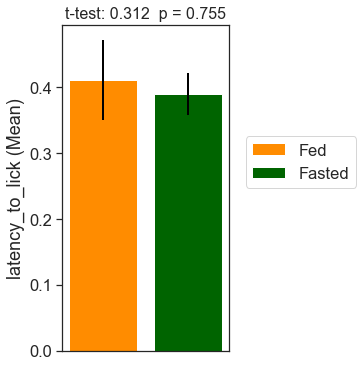

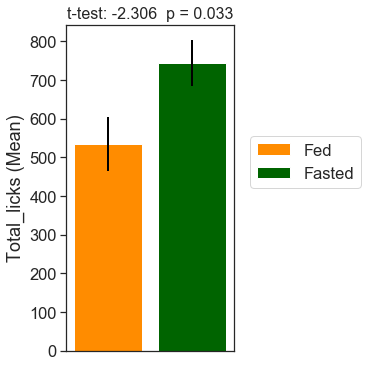

In [39]:
## Fig S5A,C: Lick summary
bar_plot(combined_latency1,combined_latency2,'latency_to_lick',param='Mean',condition=['Fed','Fasted'])
bar_plot(combined_licktotal1,combined_licktotal2,'Total_licks',param='Mean',condition=['Fed','Fasted'])